# Spectral QEP Learning with Deltas

In this paper, we demonstrate another approach to spectral learning with QEPs, learning a spectral density as a simple mixture of deltas. This has been explored, for example, as early as Lázaro-Gredilla et al., 2010.

In [1]:
import qpytorch
import torch


[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : OpenMP library 'libomp' not found.
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


## Load Data

For this notebook, we'll be using a sample set of timeseries data of BART ridership on the 5 most commonly traveled stations in San Francisco. This subsample of data was selected and processed from Pyro's examples http://docs.pyro.ai/en/stable/_modules/pyro/contrib/examples/bart.html

In [2]:
import os
import urllib.request

smoke_test = ('CI' in os.environ)

if not smoke_test and not os.path.isfile('../BART_sample.pt'):
    print('Downloading \'BART\' sample dataset...')
    urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1A6LqCHPA5lHa5S3lMH8mLMNEgeku8lRG', '../BART_sample.pt')
    torch.manual_seed(1)
    
if smoke_test:
    train_x, train_y, test_x, test_y = torch.randn(2, 100, 1), torch.randn(2, 100), torch.randn(2, 100, 1), torch.randn(2, 100)
else:
    train_x, train_y, test_x, test_y = torch.load('../BART_sample.pt', map_location='cpu')

if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

torch.Size([5, 1440, 1]) torch.Size([5, 1440]) torch.Size([5, 240, 1]) torch.Size([5, 240])


In [3]:
train_x_min = train_x.min()
train_x_max = train_x.max()

train_x = train_x - train_x_min
test_x = test_x - train_x_min

train_y_mean = train_y.mean(dim=-1, keepdim=True)
train_y_std = train_y.std(dim=-1, keepdim=True)

train_y = (train_y - train_y_mean) / train_y_std

test_y = (test_y - train_y_mean) / train_y_std

## Define a Model

The only thing of note here is the use of the kernel. For this example, we'll learn a kernel with 2048 deltas in the mixture, and initialize by sampling directly from the empirical spectrum of the data.

In [4]:
POWER = 1.0
class SpectralDeltaQEP(qpytorch.models.ExactQEP):
    def __init__(self, train_x, train_y, num_deltas, noise_init=None):
        self.power = torch.tensor(POWER)
        likelihood = qpytorch.likelihoods.QExponentialLikelihood(noise_constraint=qpytorch.constraints.GreaterThan(1e-11), power=self.power)
        likelihood.register_prior("noise_prior", qpytorch.priors.HorseshoePrior(0.1), "noise")
        likelihood.noise = 1e-2

        super(SpectralDeltaQEP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = qpytorch.means.ConstantMean()
        base_covar_module = qpytorch.kernels.SpectralDeltaKernel(
            num_dims=train_x.size(-1),
            num_deltas=num_deltas,
        )
        base_covar_module.initialize_from_data(train_x[0], train_y[0])
        self.covar_module = qpytorch.kernels.ScaleKernel(base_covar_module)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return qpytorch.distributions.MultivariateQExponential(mean_x, covar_x, power=self.power)

In [5]:
model = SpectralDeltaQEP(train_x, train_y, num_deltas=1500)

if torch.cuda.is_available():
    model = model.cuda()

## Train

In [6]:
model.train()
mll = qpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[40])

num_iters = 1000 if not smoke_test else 4

with qpytorch.settings.max_cholesky_size(0):  # Ensure we dont try to use Cholesky
    for i in range(num_iters):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        if train_x.dim() == 3:
            loss = loss.mean()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f'Iteration {i} - loss = {loss:.2f} - noise = {model.likelihood.noise.item():e}')

        scheduler.step()

Iteration 0 - loss = 2.13 - noise = 9.900989e-03
Iteration 10 - loss = 2.17 - noise = 9.134914e-03
Iteration 20 - loss = 1.94 - noise = 8.356065e-03
Iteration 30 - loss = 1.90 - noise = 7.500547e-03
Iteration 40 - loss = 1.81 - noise = 6.778868e-03
Iteration 50 - loss = 1.71 - noise = 6.703777e-03
Iteration 60 - loss = 1.64 - noise = 6.623809e-03
Iteration 70 - loss = 1.57 - noise = 6.541504e-03
Iteration 80 - loss = 1.54 - noise = 6.456869e-03
Iteration 90 - loss = 1.52 - noise = 6.373539e-03
Iteration 100 - loss = 1.51 - noise = 6.291725e-03
Iteration 110 - loss = 1.48 - noise = 6.212601e-03
Iteration 120 - loss = 1.48 - noise = 6.135635e-03
Iteration 130 - loss = 1.44 - noise = 6.060692e-03
Iteration 140 - loss = 1.45 - noise = 5.986421e-03
Iteration 150 - loss = 1.43 - noise = 5.913956e-03
Iteration 160 - loss = 1.42 - noise = 5.843284e-03
Iteration 170 - loss = 1.40 - noise = 5.773738e-03
Iteration 180 - loss = 1.35 - noise = 5.704680e-03
Iteration 190 - loss = 1.37 - noise = 5.63

In [7]:
# Get into evaluation (predictive posterior) mode
model.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), qpytorch.settings.max_cholesky_size(0), qpytorch.settings.fast_pred_var():
    test_x_f = torch.cat([train_x, test_x], dim=-2)
    observed_pred = model.likelihood(model(test_x_f))
    varz = observed_pred.variance

## Plot Results

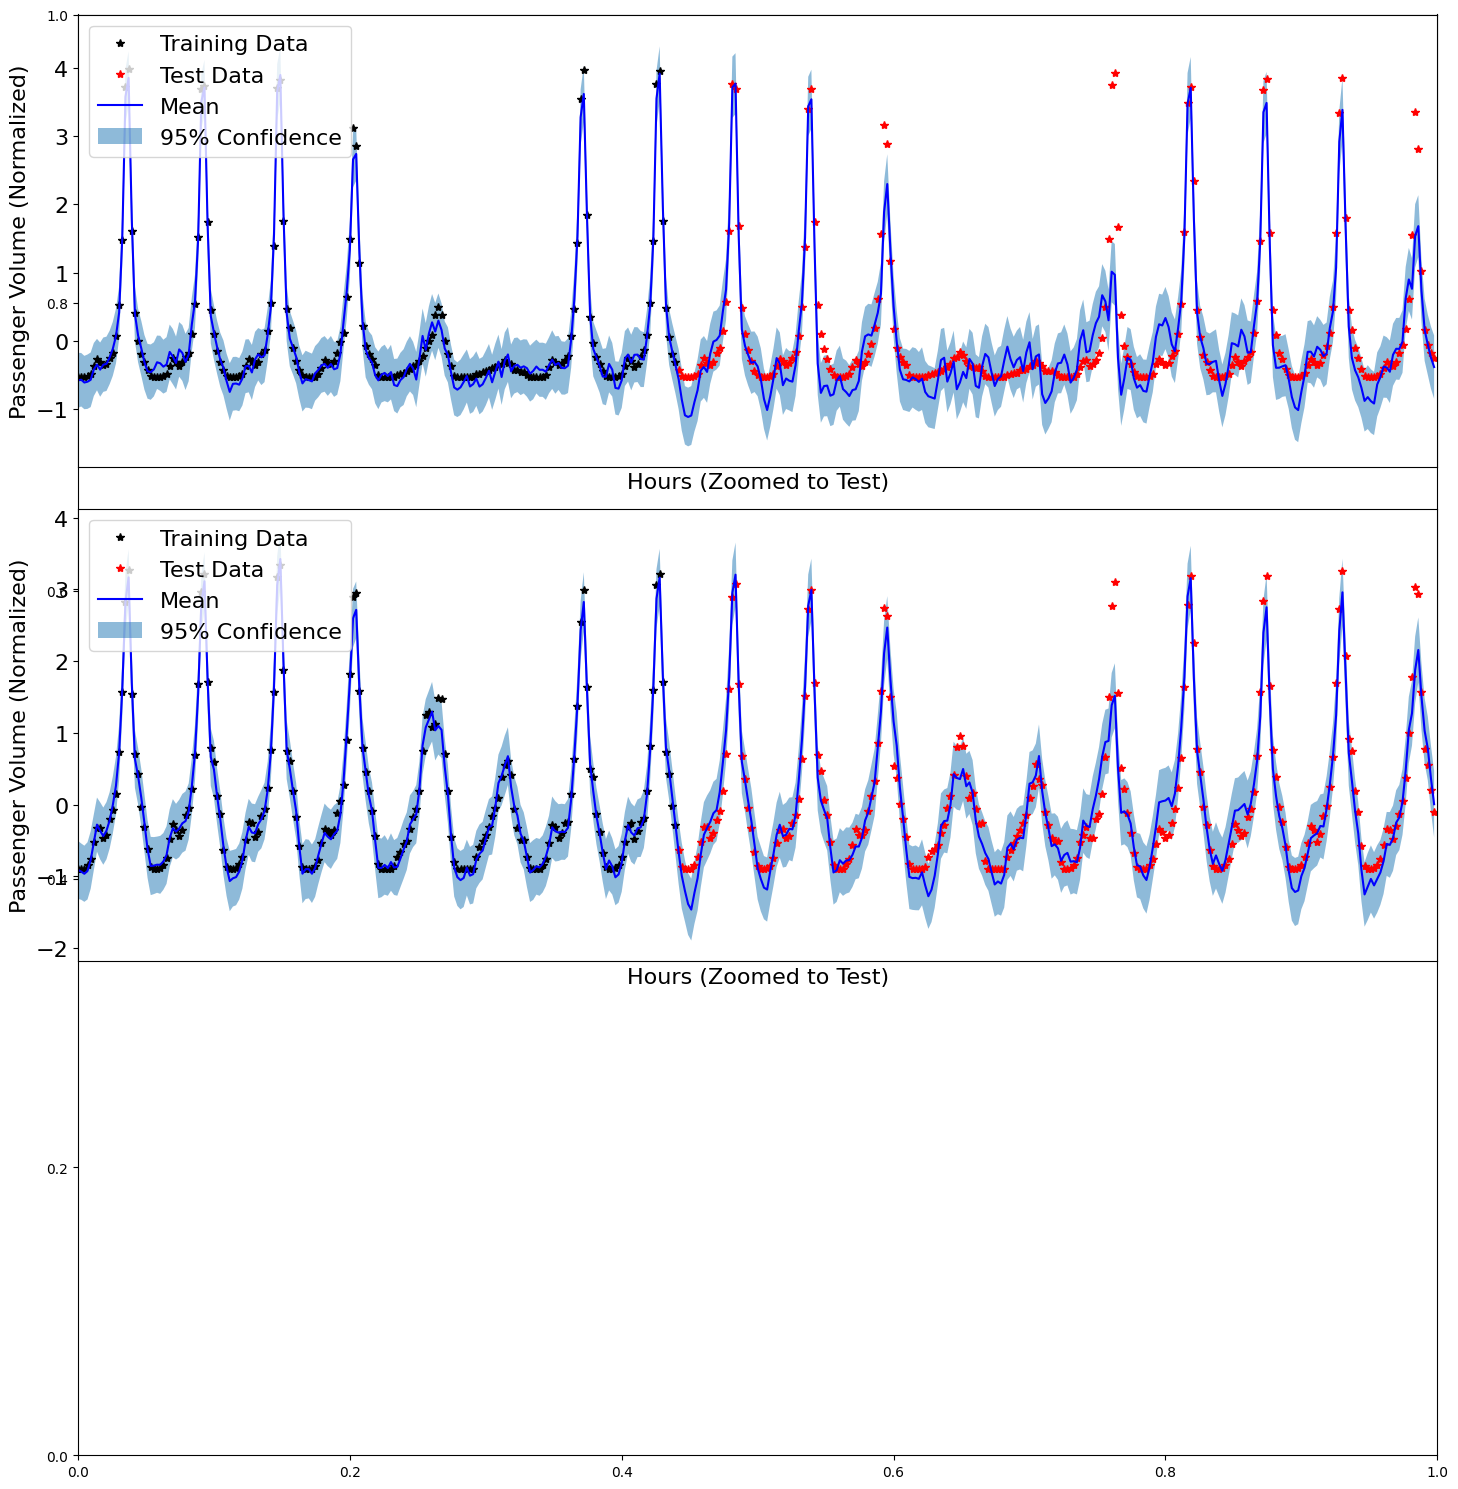

In [10]:
from matplotlib import pyplot as plt

%matplotlib inline

_task = 3

plt.subplots(figsize=(15, 15), sharex=True, sharey=True)
for _task in range(2):
    ax = plt.subplot(3, 1, _task + 1)

    with torch.no_grad():
        # Initialize plot
#         f, ax = plt.subplots(1, 1, figsize=(16, 12))

        # Get upper and lower confidence bounds
        lower = observed_pred.mean - varz.sqrt() * 1.98
        upper = observed_pred.mean + varz.sqrt() * 1.98
        lower = lower[_task] #  + weight * test_x_f.squeeze()
        upper = upper[_task] # + weight * test_x_f.squeeze()

        # Plot training data as black stars
        ax.plot(train_x[_task].detach().cpu().numpy(), train_y[_task].detach().cpu().numpy(), 'k*')
        ax.plot(test_x[_task].detach().cpu().numpy(), test_y[_task].detach().cpu().numpy(), 'r*')
        # Plot predictive means as blue line
        ax.plot(test_x_f[_task].detach().cpu().numpy(), (observed_pred.mean[_task]).detach().cpu().numpy(), 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x_f[_task].detach().cpu().squeeze().numpy(), lower.detach().cpu().numpy(), upper.detach().cpu().numpy(), alpha=0.5)
    #     ax.set_ylim([-3, 3])
        ax.legend(['Training Data', 'Test Data', 'Mean', '95% Confidence'], fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.tick_params(axis='both', which='minor', labelsize=16)
        ax.set_ylabel('Passenger Volume (Normalized)', fontsize=16)
        ax.set_xlabel('Hours (Zoomed to Test)', fontsize=16)
        ax.set_xticks([])
        
        plt.xlim([1250, 1680])

plt.tight_layout()